#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/d/Users/robin/anaconda3/python


# Install dependencies:

In [2]:
install_packages = True
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Users\robin\anaconda3

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38haa244fe_0         3.1 MB  conda-forge
    openssl-1.1.1h             |       he774522_0         5.8 MB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    tbb-2020.1                 |       he980bc4_0         167 KB  conda-forge
    umap-learn-0.4.6           |   py38h32f6830_0         111 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         9.1 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.8-1_cp38
  tbb                conda-forge/win-64::tbb-2020.1-he980bc4_0
  umap-

# Imports

In [3]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [4]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [5]:
# Set pandas print options
This will improve readability of printed pandas dataframe.


SyntaxError: invalid syntax (<ipython-input-5-804d46c41beb>, line 2)

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [7]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [8]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [9]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [11]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.47374943
n_clusters: 102 silhouette_avg: 0.34057274
n_clusters: 202 silhouette_avg: 0.2884142
n_clusters: 302 silhouette_avg: 0.29058468
n_clusters: 402 silhouette_avg: 0.307107
n_clusters: 502 silhouette_avg: 0.2934987
n_clusters: 602 silhouette_avg: 0.30069524
n_clusters: 702 silhouette_avg: 0.29785803
n_clusters: 802 silhouette_avg: 0.29316568
n_clusters: 902 silhouette_avg: 0.2893684


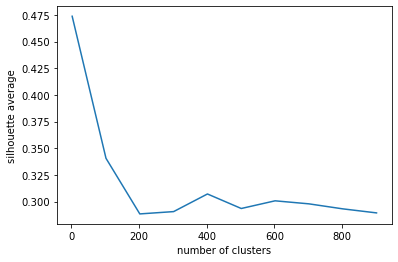

In [12]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [13]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 69     1
67     2
47     4
86     4
89     5
98     5
13     7
23     7
36     7
72     7
82     8
83     8
43     8
90    11
19    11
97    12
30    12
45    12
60    13
50    13
9     13
75    14
49    14
57    14
63    14
85    14
66    14
39    15
80    15
87    15
52    15
79    15
46    15
1     16
27    16
91    16
24    16
53    16
65    17
76    18
21    18
73    18
26    18
68    19
59    19
92    19
54    19
93    20
95    20
33    21
74    21
34    21
38    21
61    21
78    22
70    22
42    22
6     22
58    24
64    24
56    25
32    25
81    25
5     26
55    26
99    27
88    27
62    27
71    27
0     28
37    28
10    28
15    28
17    29
77    29
94    29
28    32
29    33
25    35
51    35
12    37
16    37
48    37
14    39
20    39
22    39
35    42
41    42
3     42
7     43
11    45
40    48
84    50
31    51
18    54
2     58
96    58
8     59
44    75
4     86
Name: label_kmedoids, dtype: int64


In [14]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [16]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

D:\Users\robin\anaconda3\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

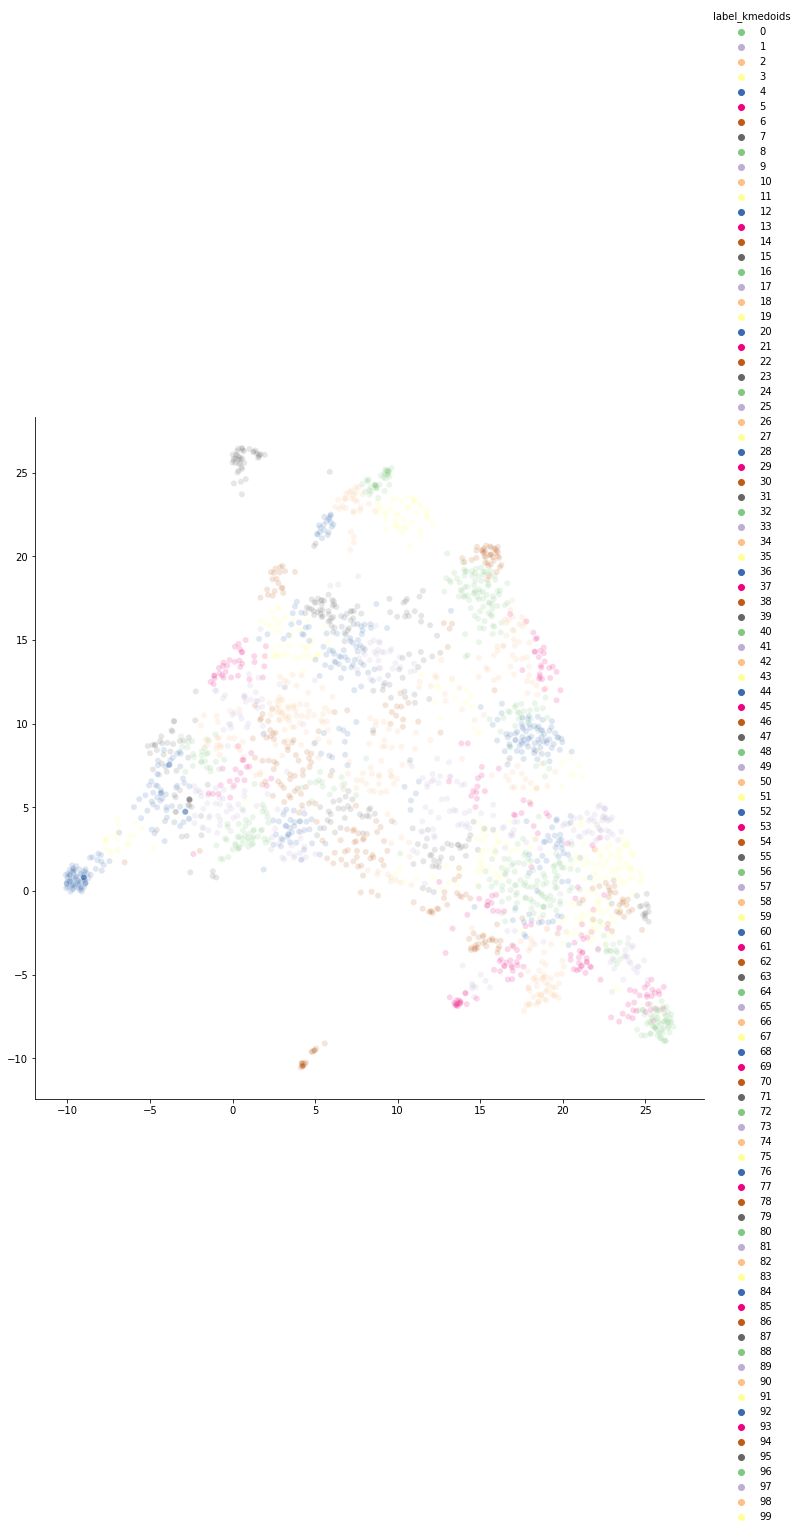

In [17]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

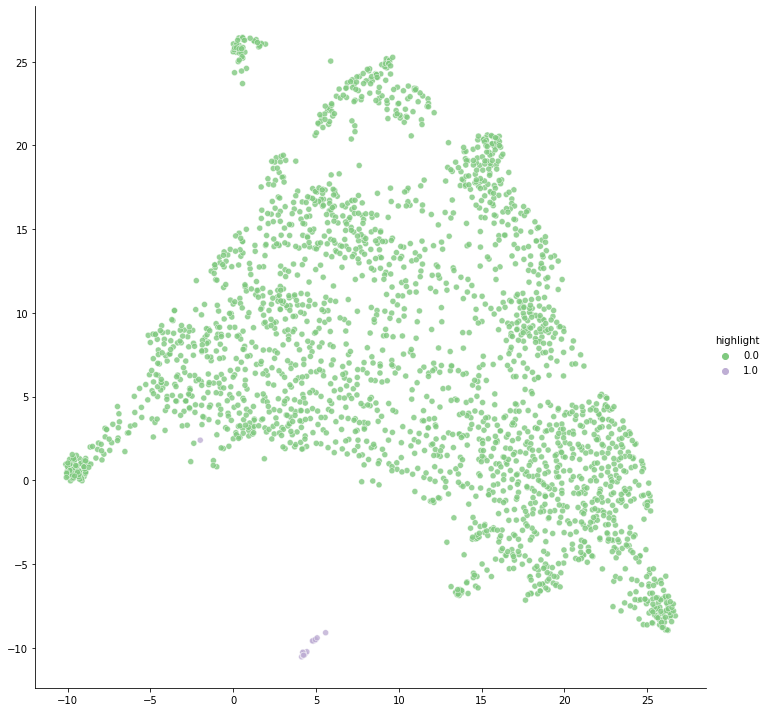

In [18]:
## Choose a cluster to higlight:
cluster_num = 6

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [19]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1692,2019-12-06 22:40:24,Hello There!,What a breath of fresh air this young lady is. Brilliant to see all young people are not brainwashed by the climate change hoax scandal.,0,What a breath of fresh air this young lady is. Brilliant to see all young\npeople are not brainwashed by the climate change hoax scandal.\n\n,-1.0,0,1.192093e-07,0.0
2400,2019-12-11 03:04:42,O.K. S,"We need more fresh air, and less talking.",1,"We need more fresh air, and less talking.\n\n",-1.0,1,0.000000e+00,0.0
623,2020-03-02 21:47:18,R L Guerrero,Great corporations just turned toward renewables and green technology. There are the big money funding Greenpeace et caterva. And also filthy personalities like you.,1,Great corporations just turned toward renewables and green technology. There\nare the big money funding Greenpeace et caterva. And also filthy personalities\nlike you.\n\n,-1.0,2,0.000000e+00,0.0
82,2020-03-08 03:00:03,Leandro Müller,She seems to have a great heart and a brilliant mind! God bless you Naomi! Thank you! 👐🏻❤,0,She seems to have a great heart and a brilliant mind! God bless you Naomi!\nThank you! 👐🏻❤\n\n,-1.0,3,5.960464e-08,0.0
1327,2019-12-10 17:22:29,Herman Karl,hahahahhaha,1,hahahahhaha\n\n,-1.0,4,0.000000e+00,0.0
804,2019-12-19 09:14:04,Blakes Liberator,"If any alarmists question or criticize Naomi, the comeback question/rebuttal should be something along the lines of: &quot;Why are you so scared of an 18-year-old girl.&quot; &quot;She&#39;s just a kid. Leave her alone and let her speak her mind.&quot;<br /><br /><br />Sound familiar?",0,"If any alarmists question or criticize Naomi, the comeback question/rebuttal\nshould be something along the lines of: ""Why are you so scared of an 18-year-\nold girl."" ""She's just a kid. Leave her alone and let her speak her mind."" \n \n \nSound familiar?\n\n",-1.0,5,0.000000e+00,0.0
2079,2019-12-15 16:23:46,Lee Vegan,"Ray Rivas ??!!! The truth TRUTH !!!! https://youtu.be/xDyW_tuJTHU 🧟‍♂️🍖🤯💀💀💀.... https://youtu.be/AMZsg4ZKmpQ Seb Alex. Brazil 🇧🇷. Cutting down the rainforest, 80% destroyed, for cattle 🐄, that is Evil !!! 😈💵💵💵💰🤯. Please watch it, I’m begging you 😢🙏🏻. All over the world 🌍 https://www.google.com/maps/place/-26.969051,+-53.873335/@-26.9678267,-53.9516129,10z/data=!3m1!1e3 🧟‍♂️🍖🤯💀💀💀... It’s the only earth we got 🌎😢, actual pictures 😭🤯. Fight back now !!! Go vegan ✅❤️😬(🐒🐵🦍✅❤️😬🦷💪😉) Meat et cetera, Number 1, cancer-causing 🍳🥓🌭🍔🍖🍕🧀 butter ☠️. Hundreds of studies. Number 2 is🥩🍗🍦🍨🍣🐟🥛🥪. Scientific fact. Pictures included. United Nations 🇺🇳, WHO, NHS.... Clogs your arteries 🧟‍♂️🍖😮😵/☠️ https://youtu.be/sb1_kY7sWZk You don’t do it with your cute little dog 🐶🤗🤥, or a budgerigar 🤗🦜🤥... 🧟‍♂️🍗🥩🥓🌭🍔🍕🍳🍣🤥👈. With bludgeoned innocent animals, like Hitler and Stalin, bludgeoned to death !!!! “As long as man continues to be the ruthless destroyer of lower living beings he will never know health or peace. For as long as men massacre animals, they will kill each other.” Pythageras. ✅❤️👏💪🌎🥳 Delicious vegan food, on YouTube. No guilt, win-win situation !!! ✅❤️🥳 https://youtu.be/tlCRMNboL3Y ✅❤️😋🍲 https://youtu.be/jemUrF18pFU 42%🥩☠️ 5,000,008 people !!! 😱. 2 minutes..",1,"??!!! The truth TRUTH !!!! \n🧟‍♂️🍖🤯💀💀💀.... Seb Alex. Brazil 🇧🇷. Cutting down\nthe rainforest, 80% destroyed, for cattle 🐄, that is Evil !!! 😈💵💵💵💰🤯. Please\nwatch it, I’m begging you 😢🙏🏻. All over the world 🌍\n\n🧟‍♂️🍖🤯💀💀💀... It’s the only earth we got 🌎😢, actual pictures 😭🤯. Fight back now\n!!! Go vegan ✅❤️😬(🐒🐵🦍✅❤️😬🦷💪😉) Meat et cetera, Number 1, cancer-causing 🍳🥓🌭🍔🍖🍕🧀\nbutter ☠️. Hundreds of studies. Number 2 is🥩🍗🍦🍨🍣🐟🥛🥪. Scientific fact. Pictures\nincluded. United Nations 🇺🇳, WHO, NHS.... Clogs your arteries 🧟‍♂️🍖😮😵/☠️\n You don’t do it with your cute little dog 🐶🤗🤥, or\na budgerigar 🤗🦜🤥... 🧟‍♂️🍗🥩🥓🌭🍔🍕🍳🍣🤥👈. With bludgeoned innocent animals, like\nHitler and Stalin, bludgeoned to death !!!! “As long as man continues to be\nthe ruthless dest

In [20]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  28 mean distance from center:  0.0008919409083318897 Proportion of replies: 14.285714285714286
1 number of samples:  16 mean distance from center:  0.0018522143363952637 Proportion of replies: 31.25
2 number of samples:  58 mean distance from center:  0.0014109858057054225 Proportion of replies: 51.724137931034484
3 number of samples:  42 mean distance from center:  0.0013856661098543555 Proportion of replies: 7.142857142857143
4 number of samples:  86 mean distance from center:  0.00040205413824878633 Proportion of replies: 50.0
5 number of samples:  26 mean distance from center:  0.0017179892893182114 Proportion of replies: 30.76923076923077
6 number of samples:  22 mean distance from center:  0.0006217848294909345 Proportion of replies: 100.0
7 number of samples:  43 mean distance from center:  0.0005548776698560687 Proportion of replies: 23.25581395348837
8 number of samples:  59 mean distance from center:  0.00036035553421243094 Proportion of replies: 59.3220

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [24]:
# Choose a cluster to print
cluster_number =   3
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 42
Average Distance from cluster center: 1.3856661098543555e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
82,2020-03-08 03:00:03,Leandro Müller,She seems to have a great heart and a brilliant mind! God bless you Naomi! Thank you! 👐🏻❤,0,She seems to have a great heart and a brilliant mind! God bless you Naomi!\nThank you! 👐🏻❤\n\n,-1,3,5.960464e-08,0.0
445,2020-02-24 11:30:28,Steven Heron,What a beautiful woman and free thinker. That is all I have to say,0,What a beautiful woman and free thinker. That is all I have to say\n\n,-1,3,2.086163e-06,0.0
1071,2019-12-15 02:54:46,Urman Taqi,She is thoughtful and eloquent- thanks much. Best wishes.,0,She is thoughtful and eloquent- thanks much. Best wishes.\n\n,-1,3,5.125999e-06,0.0
1668,2019-12-07 05:28:35,Susan Foletta,"Let&#39;s make this go viral....This young woman would run rings around Thunberg in the intelligence stakes. But then she is a thinker, not just a puppet.",0,"Let's make this go viral....This young woman would run rings around Thunberg\nin the intelligence stakes. But then she is a thinker, not just a puppet.\n\n",-1,3,6.914139e-06,0.0
1370,2019-12-09 17:34:10,Kenneth J McArthur,"Well-spoken young lady trusting herself with curiosity and demanding the truth, whatever it is.",0,"Well-spoken young lady trusting herself with curiosity and demanding the\ntruth, whatever it is.\n\n",-1,3,7.092953e-06,0.0
1553,2019-12-08 07:47:25,Justin Pavoni,This young lady is phenomenally well spoken. Well done!,0,This young lady is phenomenally well spoken. Well done!\n\n,-1,3,7.152557e-06,0.0
1248,2019-12-12 20:36:20,TheSnoozeFox,"Smart girl, takes a strong mind to see past all the brainwashing especially as a teenager",0,"Smart girl, takes a strong mind to see past all the brainwashing especially as\na teenager\n\n",-1,3,7.688999e-06,0.0
1865,2019-12-06 02:42:51,Mark Wilkinson,"A very intelligent young lady, who took it upon herself to actually think for herself, and do the research to see for herself what is really going on. I applaud her.",0,"A very intelligent young lady, who took it upon herself to actually think for\nherself, and do the research to see for herself what is really going on. I\napplaud her.\n\n",-1,3,8.285046e-06,0.0
1782,2019-12-06 09:36:27,Dan K,Man I love this girl. She is exactly what the people needed. The real truth.,0,Man I love this girl. She is exactly what the people needed. The real truth.\n\n,-1,3,9.119511e-06,0.0
1306,2019-12-11 01:16:04,Catrina Cross,Brave young lady. May she go from strength to strength.,0,Brave young lady. May she go from strength to strength.\n\n,-1,3,9.179115e-06,0.0


In [29]:
# Choose a cluster to print
cluster_number =   2
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 58
Average Distance from cluster center: 1.4109858057054225e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
623,2020-03-02 21:47:18,R L Guerrero,Great corporations just turned toward renewables and green technology. There are the big money funding Greenpeace et caterva. And also filthy personalities like you.,1,Great corporations just turned toward renewables and green technology. There\nare the big money funding Greenpeace et caterva. And also filthy personalities\nlike you.\n\n,-1,2,0.000000e+00,0.0
2304,2019-12-15 02:48:31,23lolz,"@Sean Bogan Have you ever heard the term 'Return Of Investment' ? No corporation invests in something without expecting something back. If you were to shift away from oil and fossil fuel who would stand to lose? Oil and fossil fuel Corp. Hence the large investments in anti Climate Change 'studies' , reporters , opinionists, politicians etc.",1,"@ Have you ever heard the term 'Return Of Investment' ? No\ncorporation invests in something without expecting something back. If you were\nto shift away from oil and fossil fuel who would stand to lose? Oil and fossil\nfuel Corp. Hence the large investments in anti Climate Change 'studies' ,\nreporters , opinionists, politicians etc.\n\n",-1,2,8.940697e-07,0.0
2386,2020-02-10 02:57:03,Gary Sarela,@Henriette Rozema In case there is any confusion over why human-caused climate change denial exists: Global subsidies for fossil fuels were $5.3 Trillion in 2015 or 6.5% of global GDP. www.sciencedirect.com/science/article/pii/S0305750X16304867,1,@ In case there is any confusion over why human-caused climate\nchange denial exists: Global subsidies for fossil fuels were $5.3 Trillion in\n2015 or 6.5% of global GDP.\nwww.sciencedirect.com/science/article/pii/S0305750X16304867\n\n,-1,2,9.536743e-07,0.0
728,2019-12-20 07:20:57,shai newman,It is also a trillion dollars market for green energy company subsides by the tax payers - always follow the money - the others that not making money or political gains are usually just “helpful idiots”,0,It is also a trillion dollars market for green energy company subsides by the\ntax payers - always follow the money - the others that not making money or\npolitical gains are usually just “helpful idiots”\n\n,-1,2,1.013279e-06,0.0
2401,2019-12-10 00:20:37,Gary Sarela,"@Trigger Troll The fossil fuel industry is banking on the fact that you are too stupid to realize how they avoid paying for any of the externalities of their product - you pay for climate change and healthcare costs related to pollution. The total CO2 released from coal, oil & gas over the last 30 years, is greater than the rest of all human history. https://ourworldindata.org/grapher/cumulative-co2-emissions-region?stackMode=absolute",1,"@Trigger Troll The fossil fuel industry is banking on the fact that you are\ntoo stupid to realize how they avoid paying for any of the externalities of\ntheir product - you pay for climate change and healthcare costs related to\npollution. The total CO2 released from coal, oil & gas over the last 30 years,\nis greater than the rest of all human history.\n\nregion?stackMode=absolute\n\n",-1,2,1.072884e-06,0.0
417,2020-02-24 18:40:16,Ewan Preston,"There&#39;s plenty of fossil fuel left for a least 100years. If it&#39;s all alarmist climate propaganda why are billions in various currencies being put into look for alternatives? The answer, sustainability. The world is not flat, fact. Resources are finite, fact and Increasing greenhouse gases faster than they can absorbed equal more trapped heat, fact. Please review the IPCC report and get educated.",0,"There's plenty of fossil fuel left for a least 100years. If it's all alarmist\nclimate propaganda why are billions in various currencies being put into look\nfor alternatives? The answer, sustainability. The world is not flat, fact.\nResources are finite, fact and Increasing greenhouse gases faster than they\ncan absorbed equal more trapped heat, fact. Please review the IPCC report and\nget educa

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [25]:
#which cluster would you like to assign labels to?
cluster_number = 3
#your label
label_manual = 'Positivity towars Naomi as a person'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [ ]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

In [ ]:
#which cluster would you like to assign labels to?
cluster_number = 2
#your label
label_manual = 'Discussion about (alternatives to) fossil fuels'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [ ]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
82,2020-03-08 03:00:03,Leandro Müller,She seems to have a great heart and a brilliant mind! God bless you Naomi! Thank you! 👐🏻❤,0,She seems to have a great heart and a brilliant mind! God bless you Naomi!\nThank you! 👐🏻❤\n\n,Positivity towars Naomi as a person,3,5.960464e-08,0.0
445,2020-02-24 11:30:28,Steven Heron,What a beautiful woman and free thinker. That is all I have to say,0,What a beautiful woman and free thinker. That is all I have to say\n\n,Positivity towars Naomi as a person,3,2.086163e-06,0.0
1071,2019-12-15 02:54:46,Urman Taqi,She is thoughtful and eloquent- thanks much. Best wishes.,0,She is thoughtful and eloquent- thanks much. Best wishes.\n\n,Positivity towars Naomi as a person,3,5.125999e-06,0.0
1668,2019-12-07 05:28:35,Susan Foletta,"Let&#39;s make this go viral....This young woman would run rings around Thunberg in the intelligence stakes. But then she is a thinker, not just a puppet.",0,"Let's make this go viral....This young woman would run rings around Thunberg\nin the intelligence stakes. But then she is a thinker, not just a puppet.\n\n",Positivity towars Naomi as a person,3,6.914139e-06,0.0
1370,2019-12-09 17:34:10,Kenneth J McArthur,"Well-spoken young lady trusting herself with curiosity and demanding the truth, whatever it is.",0,"Well-spoken young lady trusting herself with curiosity and demanding the\ntruth, whatever it is.\n\n",Positivity towars Naomi as a person,3,7.092953e-06,0.0
1553,2019-12-08 07:47:25,Justin Pavoni,This young lady is phenomenally well spoken. Well done!,0,This young lady is phenomenally well spoken. Well done!\n\n,Positivity towars Naomi as a person,3,7.152557e-06,0.0
1248,2019-12-12 20:36:20,TheSnoozeFox,"Smart girl, takes a strong mind to see past all the brainwashing especially as a teenager",0,"Smart girl, takes a strong mind to see past all the brainwashing especially as\na teenager\n\n",Positivity towars Naomi as a person,3,7.688999e-06,0.0
1865,2019-12-06 02:42:51,Mark Wilkinson,"A very intelligent young lady, who took it upon herself to actually think for herself, and do the research to see for herself what is really going on. I applaud her.",0,"A very intelligent young lady, who took it upon herself to actually think for\nherself, and do the research to see for herself what is really going on. I\napplaud her.\n\n",Positivity towars Naomi as a person,3,8.285046e-06,0.0
1782,2019-12-06 09:36:27,Dan K,Man I love this girl. She is exactly what the people needed. The real truth.,0,Man I love this girl. She is exactly what the people needed. The real truth.\n\n,Positivity towars Naomi as a person,3,9.119511e-06,0.0
1306,2019-12-11 01:16:04,Catrina Cross,Brave young lady. May she go from strength to strength.,0,Brave young lady. May she go from strength to strength.\n\n,Positivity towars Naomi as a person,3,9.179115e-06,0.0


In [30]:
#which cluster would you like to assign labels to?
cluster_number = 2
#your label
label_manual = 'Discussion about (alternatives to) fossil fuels'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [31]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
623,2020-03-02 21:47:18,R L Guerrero,Great corporations just turned toward renewables and green technology. There are the big money funding Greenpeace et caterva. And also filthy personalities like you.,1,Great corporations just turned toward renewables and green technology. There\nare the big money funding Greenpeace et caterva. And also filthy personalities\nlike you.\n\n,Discussion about (alternatives to) fossil fuels,2,0.000000e+00,0.0
2304,2019-12-15 02:48:31,23lolz,"@Sean Bogan Have you ever heard the term 'Return Of Investment' ? No corporation invests in something without expecting something back. If you were to shift away from oil and fossil fuel who would stand to lose? Oil and fossil fuel Corp. Hence the large investments in anti Climate Change 'studies' , reporters , opinionists, politicians etc.",1,"@ Have you ever heard the term 'Return Of Investment' ? No\ncorporation invests in something without expecting something back. If you were\nto shift away from oil and fossil fuel who would stand to lose? Oil and fossil\nfuel Corp. Hence the large investments in anti Climate Change 'studies' ,\nreporters , opinionists, politicians etc.\n\n",Discussion about (alternatives to) fossil fuels,2,8.940697e-07,0.0
2386,2020-02-10 02:57:03,Gary Sarela,@Henriette Rozema In case there is any confusion over why human-caused climate change denial exists: Global subsidies for fossil fuels were $5.3 Trillion in 2015 or 6.5% of global GDP. www.sciencedirect.com/science/article/pii/S0305750X16304867,1,@ In case there is any confusion over why human-caused climate\nchange denial exists: Global subsidies for fossil fuels were $5.3 Trillion in\n2015 or 6.5% of global GDP.\nwww.sciencedirect.com/science/article/pii/S0305750X16304867\n\n,Discussion about (alternatives to) fossil fuels,2,9.536743e-07,0.0
728,2019-12-20 07:20:57,shai newman,It is also a trillion dollars market for green energy company subsides by the tax payers - always follow the money - the others that not making money or political gains are usually just “helpful idiots”,0,It is also a trillion dollars market for green energy company subsides by the\ntax payers - always follow the money - the others that not making money or\npolitical gains are usually just “helpful idiots”\n\n,Discussion about (alternatives to) fossil fuels,2,1.013279e-06,0.0
2401,2019-12-10 00:20:37,Gary Sarela,"@Trigger Troll The fossil fuel industry is banking on the fact that you are too stupid to realize how they avoid paying for any of the externalities of their product - you pay for climate change and healthcare costs related to pollution. The total CO2 released from coal, oil & gas over the last 30 years, is greater than the rest of all human history. https://ourworldindata.org/grapher/cumulative-co2-emissions-region?stackMode=absolute",1,"@Trigger Troll The fossil fuel industry is banking on the fact that you are\ntoo stupid to realize how they avoid paying for any of the externalities of\ntheir product - you pay for climate change and healthcare costs related to\npollution. The total CO2 released from coal, oil & gas over the last 30 years,\nis greater than the rest of all human history.\n\nregion?stackMode=absolute\n\n",Discussion about (alternatives to) fossil fuels,2,1.072884e-06,0.0
417,2020-02-24 18:40:16,Ewan Preston,"There&#39;s plenty of fossil fuel left for a least 100years. If it&#39;s all alarmist climate propaganda why are billions in various currencies being put into look for alternatives? The answer, sustainability. The world is not flat, fact. Resources are finite, fact and Increasing greenhouse gases faster than they can absorbed equal more trapped heat, fact. Please review the IPCC report and get educated.",0,"There's plenty of fossil fuel left for a least 100years. If it's all alarmist\nclimate propaganda why are billions in various currencies being put into look\nfor alternatives